# K-Nearest Neighbours (Zoo Dataset)
This notebook implements **KNN classification** on the Zoo dataset.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA


In [2]:

# Load dataset
df = pd.read_csv("Zoo.csv")
df.head()


,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [3]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   animal name  101 non-null    object
 1   hair         101 non-null    int64 
 2   feathers     101 non-null    int64 
 3   eggs         101 non-null    int64 
 4   milk         101 non-null    int64 
 5   airborne     101 non-null    int64 
 6   aquatic      101 non-null    int64 
 7   predator     101 non-null    int64 
 8   toothed      101 non-null    int64 
 9   backbone     101 non-null    int64 
 10  breathes     101 non-null    int64 
 11  venomous     101 non-null    int64 
 12  fins         101 non-null    int64 
 13  legs         101 non-null    int64 
 14  tail         101 non-null    int64 
 15  domestic     101 non-null    int64 
 16  catsize      101 non-null    int64 
 17  type         101 non-null    int64 
dtypes: int64(17), object(1)
memory usage: 14.3+ KB


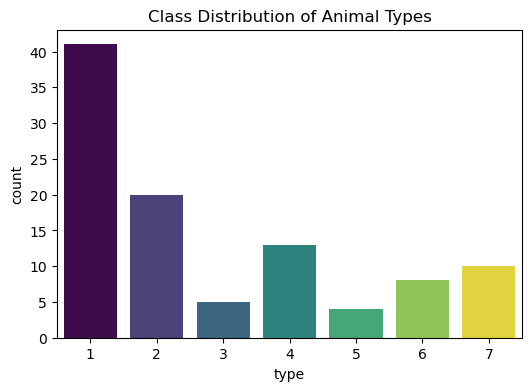

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x="type", hue="type", data=df, palette="viridis", legend=False)
plt.title("Class Distribution of Animal Types")
plt.show()


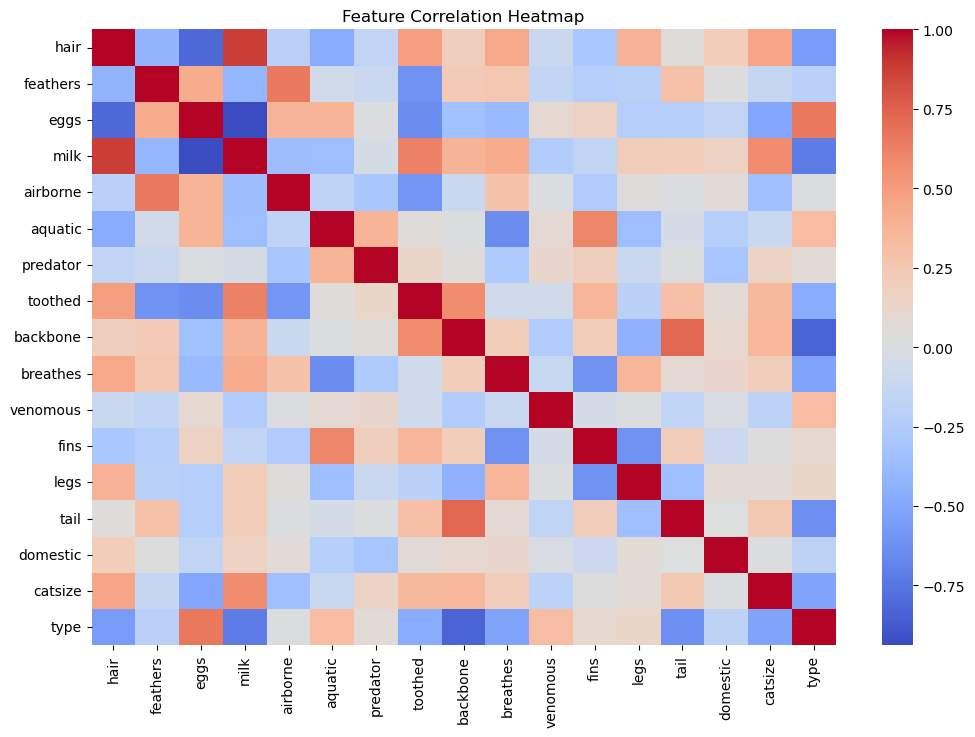

In [7]:

plt.figure(figsize=(12,8))
sns.heatmap(df.drop(columns=["animal name"]).corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [8]:

# Drop 'animal name'
X = df.drop(columns=["animal name", "type"])
y = df["type"]

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

min_count = min(pd.Series(y_train).value_counts())
n_splits = max(2, min(5, min_count))   # use up to 5 but not more than smallest class count

knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1,15), "metric": ["euclidean","manhattan"]}

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
grid = GridSearchCV(knn, param_grid, cv=cv)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)


Best parameters: {'metric': 'manhattan', 'n_neighbors': np.int64(1)}
Best cross-validation score: 0.949667616334283


Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



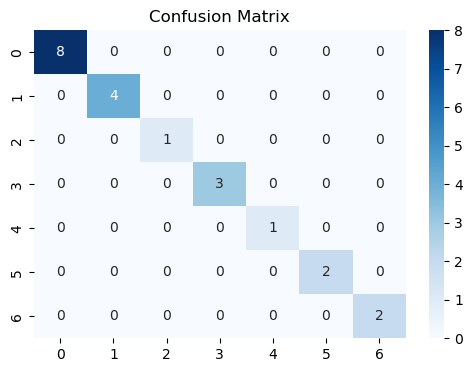

In [17]:

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


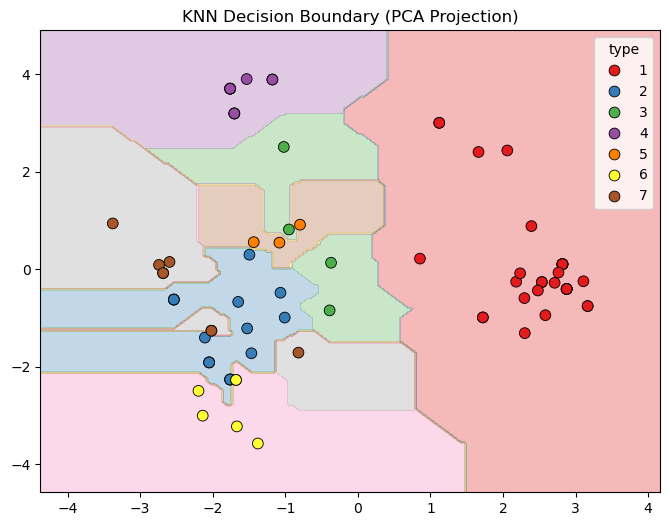

In [9]:

# Reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'], metric=grid.best_params_['metric'])
knn.fit(X_train_pca, y_train)

# Plot decision boundaries
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="Set1")
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train, palette="Set1", s=60, edgecolor="k")
plt.title("KNN Decision Boundary (PCA Projection)")
plt.show()


# Interview Question & Answers

**1. Key hyperparameters in KNN**
- K (number of neighbors): Controls how many neighbors are considered.

- Distance metric: Euclidean, Manhattan, Minkowski, etc.

- Weights: uniform (equal), distance (closer points influence more).

- Algorithm: auto, kd_tree, ball_tree, brute ( affects speed).

**2. Distance Metrics Can be Used in KNN**
- Euclidean distance: Straight-line distance between two points in continuous space.


- Manhattan distance: Sum of absolute differences, like moving along grid blocks.


- Minkowski distance: Generalized distance metric that includes both Euclidean and Manhattan as special cases.


- Hamming distance: Counts how many positions differ between two categorical or binary values.

